<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/Deepfake_Detection_Phase_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## sp21 Semester Project
Jackson Hoenig

# Description

1.  Watch the lectures in Module 8.
2.  With the best model obtained from the previous step, apply various techniques of regularization (Batchnormalization, Dropout, L2 regularization, etc.) and study the improvement in accuracy
3.  Plot your learning curves and include them in your report

#Initial Setup

##Imports

In [33]:
# !pip install tensorflow==2.2.0
import tensorflow
print(tensorflow.__version__)

2.4.1


In [34]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import callbacks
from keras.layers import Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [35]:
#Make sure the Earlystop callback is used with the validation set
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)

##Prevent Google Colab From Stalling

In [36]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


#Split the Training Data

In [37]:
print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [38]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake

In [39]:
# !rm SplitDataset/train/real/*
# !rm SplitDataset/train/fake/*
# !rm SplitDataset/test/real/*
# !rm SplitDataset/test/fake/*
# !rm SplitDataset/valid/real/*
# !rm SplitDataset/valid/fake/*
# !rmdir SplitDataset/train/real
# !rmdir SplitDataset/train/fake
# !rmdir SplitDataset/test/real
# !rmdir SplitDataset/test/fake
# !rmdir SplitDataset/valid/real
# !rmdir SplitDataset/valid/fake
# !rmdir SplitDataset/train
# !rmdir SplitDataset/test
# !rmdir SplitDataset/valid
# !rmdir -p SplitDataset

In [40]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [41]:
import random
import os
import imageio
#split real file names into
#train valid and test
#random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  if count % 5 == 0 or count % 5 == 2 or count % 5 == 4: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count % 5 == 1: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;


With the fake images we need to make sure the same videos are kept together so they do not get split among the datasets. there are 8 videos so we will take the first 4 videos for training, the next 2 for validation and last 2 for test set.

In [42]:
count = 0
for file in fakeFileNames:
  if file.startswith('gen1') or file.startswith('gen3') or file.startswith('gen4') or file.startswith('gen5'): #first 60%
    # print("Train dataset" + str(count) + file)
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif file.startswith('gen6') or file.startswith('gen7'): #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


In [43]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/valid/real: 101
SplitDataset/valid/fake: 73
-----
SplitDataset/test/real: 100
SplitDataset/test/fake: 73
-----
SplitDataset/train/real: 302
SplitDataset/train/fake: 215
-----


In [44]:
#Add imbalence library.
#GNN better than CNN.
#see all misclassified images.
#

In [45]:
print(train_dir)
print(validation_dir)
print(test_dir)

SplitDataset/train
SplitDataset/valid
SplitDataset/test


## Create Data Generators

In [46]:
#get a validation set generator
train_datagen = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 517 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [47]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

Found 174 images belonging to 2 classes.


In [48]:
#get a test set generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

Found 173 images belonging to 2 classes.


Found 517 images belonging to 2 classes.


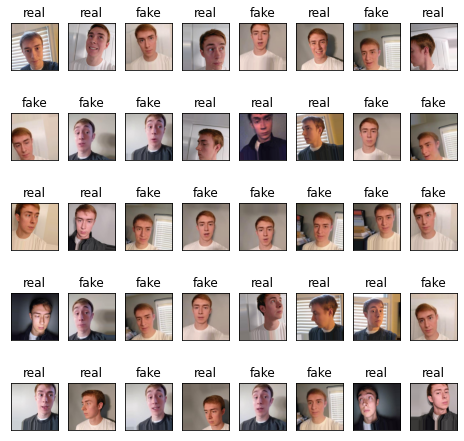

In [49]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

Found 174 images belonging to 2 classes.


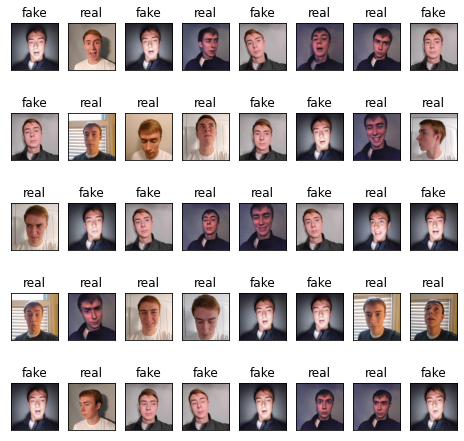

In [50]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in validate_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

In [51]:
# model = Sequential()
# model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
# model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
# model.add( Flatten() )
# model.add( Dense( 2, activation = 'sigmoid' ) )
# model.summary()
# model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )
# model = model.fit(  train_generator, validation_data=validation_generator, epochs = 20, batch_size = 64 )

#Take the best model from Phase 4.

In [52]:
originalModel = Sequential()
originalModel.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
originalModel.add( MaxPool2D(4, 4) )
originalModel.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
originalModel.add( Flatten() )
originalModel.add( Dense( 2, activation = 'relu' ) )
originalModel.add( Dense( 2, activation = 'sigmoid' ) )
originalModel.summary()
originalModel.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
originalHistory = originalModel.fit(  train_generator, validation_data=validation_generator, epochs = 20, batch_size = 64 )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 119074    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 124,600
Trainable params: 124,600
Non-trainable params: 0
________________________________________________

In [53]:
model8 = Sequential()
model8.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model8.add( MaxPool2D(4, 4) )
model8.add( Conv2D( 8, ( 3, 3 ), activation = 'relu' ) )
model8.add( Flatten() )
model8.add( Dense( 2, activation = 'sigmoid' ) )
model8.summary()
model8.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history8 = model8.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 8)         2312      
_________________________________________________________________
flatten_2 (Flatten)          (None, 29768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 59538     
Total params: 62,746
Trainable params: 62,746
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 9s 62ms/step - loss: 0.6633 - accuracy: 0.6217 - val_loss: 1.3

In [54]:
model5 = Sequential()
model5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
model5.add( MaxPool2D(4, 4) )
model5.add( Flatten() )
model5.add( Dense( 2, activation = 'sigmoid' ) )
model5.summary()
model5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history5 = model5.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 127010    
Total params: 127,458
Trainable params: 127,458
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
130/130 [==============================] - 8s 62ms/step - loss: 1.7262 - accuracy: 0.5567 - val_loss: 0.7212 - val_accuracy: 0.5747
Epoch 2/35
130/130 [==============================] - 8s 60ms/step - loss: 0.3649 - accuracy: 0.8407 - 

#Residual Models

In [73]:
modelRes1 = Sequential()
modelRes1.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
modelRes1.add( MaxPool2D(4, 4) )
modelRes1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelRes1.add( Flatten() )
modelRes1.add( Dense( 2, activation = 'relu' ) )
modelRes1.add( Dense( 2, activation = 'sigmoid' ) )
modelRes1.summary()
modelRes1.compile( optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyRes1 = modelRes1.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_484 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_485 (Conv2D)          (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_15 (Flatten)         (None, 59536)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 119074    
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 6         
Total params: 124,600
Trainable params: 124,600
Non-trainable params: 0
_______________________________________________

In [67]:
input_img = Input(shape=(256,256,3))
output1 = Conv2D(32, (3, 3), activation='relu')(input_img)
for i in range(16):
    output2 = Conv2D(32, (3, 3), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Conv2D(32, (3, 3), padding = 'same', activation='relu')(output2)
    output2 = Dropout(0.2)(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)
output4 = Dense(units = 16, activation = 'relu')(output3)
output5 = Dense(units = 16, activation = 'relu')(output4)
output6 = Dense(units = 2, activation = 'sigmoid')(output5)
modelRes2 = Model(inputs=input_img, outputs=output6)
modelRes2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(modelRes2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 254, 254, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, 254, 254, 32) 9248        conv2d_285[0][0]                 
__________________________________________________________________________________________________
batch_normalization_130 (BatchN (None, 254, 254, 32) 128         conv2d_286[0][0]                 
____________________________________________________________________________________________

In [68]:
historyRes2 = modelRes2.fit( train_generator, validation_data=validation_generator, epochs = 4, batch_size = 10 )

Epoch 1/4
130/130 [==============================] - 46s 315ms/step - loss: 702.7021 - accuracy: 0.5070 - val_loss: 4.7069 - val_accuracy: 0.5805
Epoch 2/4
130/130 [==============================] - 40s 307ms/step - loss: 13.3796 - accuracy: 0.6164 - val_loss: 14.2979 - val_accuracy: 0.5805
Epoch 3/4
130/130 [==============================] - 40s 305ms/step - loss: 6.6340 - accuracy: 0.6530 - val_loss: 1.4441 - val_accuracy: 0.4943
Epoch 4/4
130/130 [==============================] - 40s 305ms/step - loss: 2.1071 - accuracy: 0.7281 - val_loss: 1.8158 - val_accuracy: 0.5345


In [60]:
input_img = Input(shape=(256,256,3))
output1 = Conv2D(16, (3, 3), activation='relu')(input_img)
for i in range(32):
    output2 = Conv2D(16, (3, 3), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Conv2D(16, (3, 3), padding = 'same', activation='relu')(output2)
    output2 = Dropout(0.3)(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)
output4 = Dense(units = 16, activation = 'relu')(output3)
output5 = Dense(units = 16, activation = 'relu')(output4)
output6 = Dense(units = 2, activation = 'sigmoid')(output5)
modelRes3 = Model(inputs=input_img, outputs=output6)
modelRes3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(modelRes3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 254, 254, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 254, 254, 16) 2320        conv2d_47[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 254, 254, 16) 64          conv2d_48[0][0]                  
____________________________________________________________________________________________

In [61]:
historyRes3 = modelRes3.fit( train_generator, validation_data=validation_generator, epochs = 8, batch_size = 10 )

Epoch 1/8
130/130 [==============================] - 55s 347ms/step - loss: 245.8081 - accuracy: 0.5926 - val_loss: 0.6905 - val_accuracy: 0.5805
Epoch 2/8
130/130 [==============================] - 44s 335ms/step - loss: 0.6899 - accuracy: 0.5675 - val_loss: 0.6872 - val_accuracy: 0.5805
Epoch 3/8
130/130 [==============================] - 44s 336ms/step - loss: 0.6855 - accuracy: 0.5942 - val_loss: 0.6849 - val_accuracy: 0.5805
Epoch 4/8
130/130 [==============================] - 44s 335ms/step - loss: 0.6833 - accuracy: 0.5889 - val_loss: 0.6830 - val_accuracy: 0.5805
Epoch 5/8
130/130 [==============================] - 44s 336ms/step - loss: 0.6735 - accuracy: 0.6290 - val_loss: 0.6820 - val_accuracy: 0.5805
Epoch 6/8
130/130 [==============================] - 44s 336ms/step - loss: 0.6901 - accuracy: 0.5411 - val_loss: 0.6813 - val_accuracy: 0.5805
Epoch 7/8
130/130 [==============================] - 44s 336ms/step - loss: 0.6861 - accuracy: 0.5602 - val_loss: 0.6808 - val_accurac

In [ ]:
historyRes3 = modelRes3.fit( train_generator, validation_data=validation_generator, epochs = 8, batch_size = 10 )

# Regularization

In [62]:
model1 = Sequential()
model1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(16):
    model1.add(BatchNormalization())
    model1.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model1.add(Dropout(rate=0.2))
    model1.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model1.add( MaxPool2D(4, 4) )
model1.add( Flatten() )
model1.add( Dense( 2, activation = 'sigmoid' ) )
model1.summary()
model1.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history1 = model1.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_50 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_50 (Dropout)         (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_51 (Batc (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 254, 254, 4)      

In [63]:
model2 = Sequential()
model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(16):
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model2.add(Dropout(rate=0.5))
    model2.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model2.add( Flatten() )
model2.add( Dense( 2, activation = 'relu' ) )
model2.add( Dense( 2, activation = 'sigmoid' ) )
model2.summary()
model2.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history2 = model2.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_66 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_66 (Dropout)         (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_67 (Batc (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 254, 254, 4)      

In [66]:
model3 = Sequential()
model3.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(16):
    model3.add(BatchNormalization())
    model3.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model3.add(Dropout(rate=0.2))
    model3.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model3.add( MaxPool2D(4, 4) )
model3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model3.add( Flatten() )
model3.add( Dense( 2, activation = 'relu' ) )
model3.add( Dense( 2, activation = 'sigmoid' ) )
model3.summary()
model3.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history3 = model3.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_250 (Conv2D)          (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization_114 (Bat (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 254, 254, 4)       2308      
_________________________________________________________________
dropout_114 (Dropout)        (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_115 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 254, 254, 4)      

In [65]:
model4 = Sequential()
model4.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(16):
    model4.add(BatchNormalization())
    model4.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model4.add(Dropout(rate=0.2))
    model4.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model4.add( MaxPool2D(4, 4) )
model4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model4.add( Flatten() )
model4.add( Dense( 2, activation = 'relu' ) )
model4.add( Dense( 2, activation = 'sigmoid' ) )
model4.summary()
model4.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history4 = model4.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_215 (Conv2D)          (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization_98 (Batc (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 254, 254, 4)       2308      
_________________________________________________________________
dropout_98 (Dropout)         (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_99 (Batc (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 254, 254, 4)      

In [64]:
model5 = Sequential()
model5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(16):
    model5.add(BatchNormalization())
    model5.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model5.add(Dropout(rate=0.5))
    model5.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model5.add( MaxPool2D(4, 4) )
model5.add( Flatten() )
model5.add( Dense( 2, activation = 'sigmoid' ) )
model5.summary()
model5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history5 = model5.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_82 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_82 (Dropout)         (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_83 (Batc (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 254, 254, 4)      

In [69]:
model6 = Sequential()
model6.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(8):
    model6.add(BatchNormalization())
    model6.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model6.add(Dropout(rate=0.5))
    model6.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model6.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model6.add( MaxPool2D(4, 4) )
model6.add( Flatten() )
model6.add( Dense( 2, activation = 'sigmoid' ) )
model6.summary()
model6.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history6 = model6.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_318 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_146 (Bat (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_319 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_146 (Dropout)        (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_320 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_147 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_321 (Conv2D)          (None, 254, 254, 4)      

In [70]:
model7 = Sequential()
model7.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(8):
    model7.add(BatchNormalization())
    model7.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model7.add(Dropout(rate=0.2))
    model7.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model7.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model7.add( MaxPool2D(4, 4) )
model7.add( Flatten() )
model7.add( Dense( 2, activation = 'sigmoid' ) )
model7.summary()
model7.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history7 = model7.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_336 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_154 (Bat (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_337 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_154 (Dropout)        (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_338 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_155 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_339 (Conv2D)          (None, 254, 254, 4)     

In [71]:
model8 = Sequential()
model8.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )

for i in range(64):
    model8.add(BatchNormalization())
    model8.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))
    model8.add(Dropout(rate=0.5))
    model8.add(Conv2D(filters = 4, kernel_size = 3, activation = 'relu', padding='same'))

model8.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model8.add( MaxPool2D(4, 4) )
model8.add( Flatten() )
model8.add( Dense( 2, activation = 'sigmoid' ) )
model8.summary()
model8.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history8 = model8.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_354 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_162 (Bat (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_355 (Conv2D)          (None, 254, 254, 4)       580       
_________________________________________________________________
dropout_162 (Dropout)        (None, 254, 254, 4)       0         
_________________________________________________________________
conv2d_356 (Conv2D)          (None, 254, 254, 4)       148       
_________________________________________________________________
batch_normalization_163 (Bat (None, 254, 254, 4)       16        
_________________________________________________________________
conv2d_357 (Conv2D)          (None, 254, 254, 4)     

#Evaluate on the test set

In [87]:
testing_loss, testing_acc =originalModel.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Previous Phase Augmentation")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model1.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 1")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model2.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 2")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model3.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 3")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model4.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 4")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model5.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 5")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =model6.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Model 6")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

testing_loss, testing_acc =originalModel.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("model from previous project")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes1.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 1")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes2.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 2")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes3.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 3")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

___________________________________
Previous Phase Augmentation
testing_acc: 0.5780346989631653
testing_loss: 0.68091881275177
___________________________________
Model 1
testing_acc: 0.4219653308391571
testing_loss: 0.7006580829620361
___________________________________
Model 2
testing_acc: 0.5780346989631653
testing_loss: 0.6809695363044739
___________________________________
Model 3
testing_acc: 0.5780346989631653
testing_loss: 0.6809581518173218
___________________________________
Model 4
testing_acc: 0.5780346989631653
testing_loss: 0.680943489074707
___________________________________
Model 5
testing_acc: 0.4219653308391571
testing_loss: 0.6992281675338745
___________________________________
Model 6
testing_acc: 0.4219653308391571
testing_loss: 0.6970016956329346
___________________________________
model from previous project
testing_acc: 0.5780346989631653
testing_loss: 0.6809187531471252
___________________________________
Residual Model 1
testing_acc: 0.5780346989631653
testin

#Plot the curves

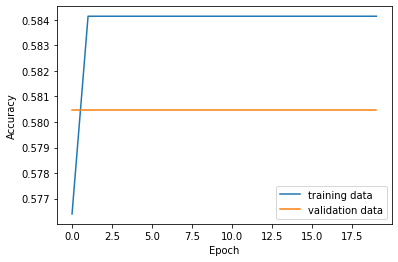

<Figure size 432x288 with 0 Axes>

In [75]:
plt.plot(originalHistory.history['accuracy'])
plt.plot(originalHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("original plot.png")

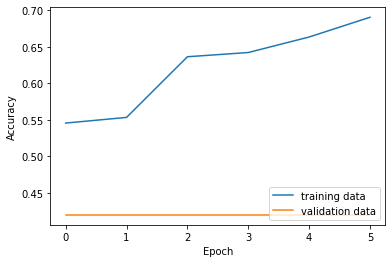

<Figure size 432x288 with 0 Axes>

In [76]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot1.png")

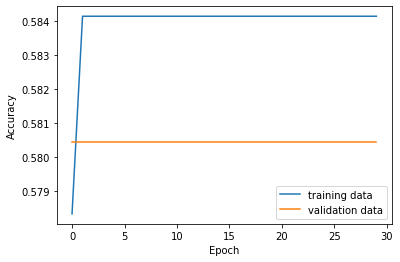

<Figure size 432x288 with 0 Axes>

In [77]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot2.png")

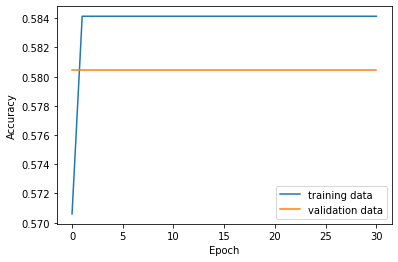

<Figure size 432x288 with 0 Axes>

In [78]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot3.png")

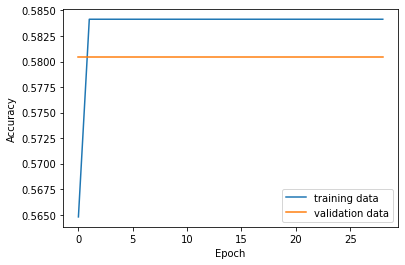

<Figure size 432x288 with 0 Axes>

In [79]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot4.png")

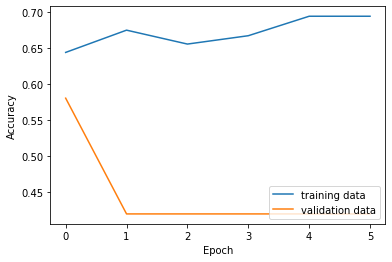

<Figure size 432x288 with 0 Axes>

In [80]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot5.png")

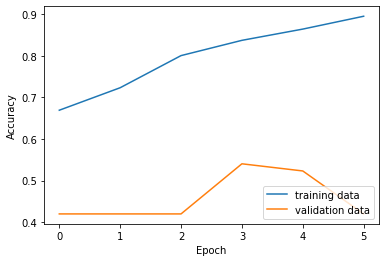

<Figure size 432x288 with 0 Axes>

In [81]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot6.png")

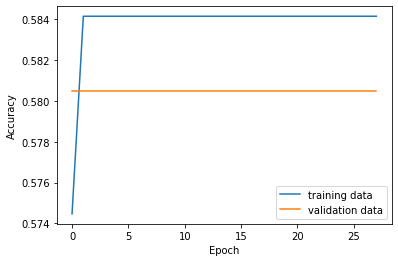

<Figure size 432x288 with 0 Axes>

In [83]:
plt.plot(historyRes1.history['accuracy'])
plt.plot(historyRes1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot7.png")

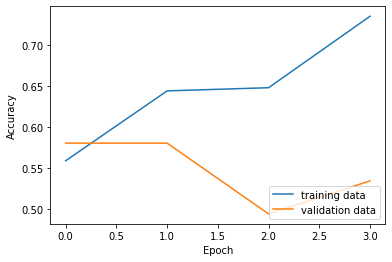

<Figure size 432x288 with 0 Axes>

In [84]:
plt.plot(historyRes2.history['accuracy'])
plt.plot(historyRes2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot8.png")

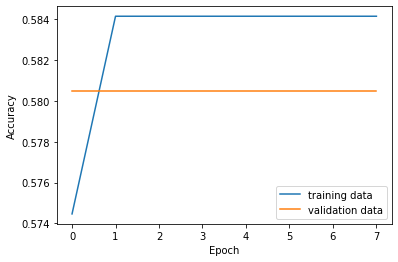

<Figure size 432x288 with 0 Axes>

In [85]:
plt.plot(historyRes3.history['accuracy'])
plt.plot(historyRes3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot9.png")

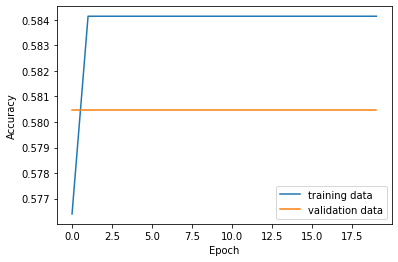

<Figure size 432x288 with 0 Axes>

In [86]:
plt.plot(originalHistory.history['accuracy'])
plt.plot(originalHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot10.png")